## Task A: optimize a region

In [257]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import pypsa 
import warnings
warnings.filterwarnings("ignore")

# Import datasets for region and year of interest
country = "FIN"
year = 2015

demand = pd.read_csv("electricity_demand.csv", sep=";", index_col=0, parse_dates=True )
demand = demand[country].loc[demand.index.year == year]
demand.index = demand.index.tz_localize(None)

onshore_all = pd.read_csv("onshore_wind_1979-2017.csv", sep=";", index_col=0, parse_dates=True)
onshore_all.index = onshore_all.index.tz_localize(None)
onshore_2015 = onshore_all[country].loc[onshore_all.index.year == year]

solar_all = pd.read_csv("pv_optimal.csv", sep=";", index_col=0, parse_dates=True)
solar_all.index = solar_all.index.tz_localize(None)
solar_2015 = solar_all[country].loc[solar_all.index.year == year]

heat = pd.read_csv("heat_demand.csv", sep=";", index_col=0, parse_dates=True)
heat = heat[country].loc[solar_2015.index.year == year]
heat.index = heat.index.tz_localize(None)

# Get snapshots for the year of interest
snapshots = demand.index


In [258]:
# Annuity function for converging capital costs to annualized costs
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

# Import costs from PyPSA technology data
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_2030.csv"
costs = pd.read_csv(url, index_col=[0, 1])

# Convert cost units to MW
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

# Define default values for missing parameters 
defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}

costs = costs.value.unstack().fillna(defaults)

# Set OCGT cost and emissions to gas values
costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

# Set OCGT cost and emissions to gas values
costs.at["biomass CHP", "CO2 intensity"] = costs.at["solid biomass", "CO2 intensity"]
costs.at["biomass CHP", "fuel"] = costs.at["solid biomass", "fuel"]

# Compute marginal costs
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

# Compute capital costs
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

# Extract relevant costs with nicer names
wind_capital = costs.at["onwind", "capital_cost"] #EUR/MW/a
wind_marginal = costs.at["onwind", "marginal_cost"] #EUR/MWh
solar_capital = costs.at["solar", "capital_cost"] #EUR/MW/a
solar_marginal = costs.at["solar", "marginal_cost"] #EUR/MWh
gas_capital = costs.at["OCGT", "capital_cost"] #EUR/MW/a
gas_marginal = costs.at["OCGT", "marginal_cost"] #EUR/MWh
nuclear_capital = costs.at["nuclear", "capital_cost"] #EUR/MW/a
nuclear_marginal = costs.at["nuclear", "marginal_cost"] #EUR/MWh
pumped_hydro_capital = costs.at["Pumped-Storage-Hydro-store", "capital_cost"] 
pumped_hydro_marginal = costs.at["Pumped-Storage-Hydro-store", "marginal_cost"] #EUR/MWh
biomass_capital = costs.at["biomass CHP", "capital_cost"] #EUR/MW/a
biomass_marginal = costs.at["biomass CHP", "marginal_cost"] #EUR/MWh
coal_capital = costs.at["coal", "capital_cost"] #EUR/MW/a
coal_marginal = costs.at["coal", "marginal_cost"] #EUR/MWh

In [259]:
import os
import sys
import contextlib

# Function to suppress stdout
@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as fnull:
        old_stdout = sys.stdout
        sys.stdout = fnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# Create a PyPSA network
network = pypsa.Network()
network.set_snapshots(snapshots.values)


# Add electricity bus
network.add("Bus", "FIN_el")

# Add carriers
carriers = [
    "onwind",
    "solar",
    "OCGT",
    "nuclear",
    "biomass CHP",
    "coal"
]

colors = ["dodgerblue", "gold", "brown", "blue", "green", "orange", "red"]

# Add carriers to the network with CO2 emissions and colors
for i in range(len(carriers)):
    network.add("Carrier", carriers[i], co2_emissions=costs.at[carriers[i], "CO2 intensity"], color=colors[i])


# Add electricity load
network.add("Load", "el_load", bus="FIN_el", p_set=demand.values)


# Add generators
network.add("Generator", "onwind", bus="FIN_el", p_nom_extendable=True, p_max_pu=onshore_2015.values, marginal_cost=wind_marginal, capital_cost=wind_capital, carrier="onwind")
network.add("Generator", "solar", bus="FIN_el", p_nom_extendable=True, p_max_pu=solar_2015.values, marginal_cost=solar_marginal, capital_cost=solar_capital, carrier="solar")
network.add("Generator", "OCGT", bus="FIN_el", p_nom_extendable=True, p_max_pu=1, marginal_cost=gas_marginal, efficiency = costs.at["OCGT","efficiency"], capital_cost=gas_capital, carrier="OCGT")
network.add("Generator", "nuclear", bus="FIN_el", p_nom_extendable=True, p_max_pu=1, marginal_cost=nuclear_marginal, efficiency = costs.at["nuclear","efficiency"], capital_cost=nuclear_capital, carrier="nuclear")
network.add("Generator", "biomass CHP", bus="FIN_el", p_nom_extendable=True, p_max_pu=1, marginal_cost=biomass_marginal, efficiency = costs.at["biomass CHP","efficiency"], capital_cost=biomass_capital, carrier="biomass CHP")
network.add("Generator", "coal", bus="FIN_el", p_nom_extendable=True, p_max_pu=1, marginal_cost=coal_marginal, efficiency = costs.at["coal","efficiency"], capital_cost=coal_capital, carrier="coal")


# Optimize with reduced output
# Suppress the solver output by using the context manager
with suppress_stdout():
    network.optimize(solver_name='gurobi', solver_options={'outputflag': 0})

INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 11.73it/s]
INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-f0nuqvcp.lp
INFO:gurobipy:Reading time = 0.38 seconds
INFO:gurobipy:obj: 113886 rows, 52566 columns, 206217 nonzeros


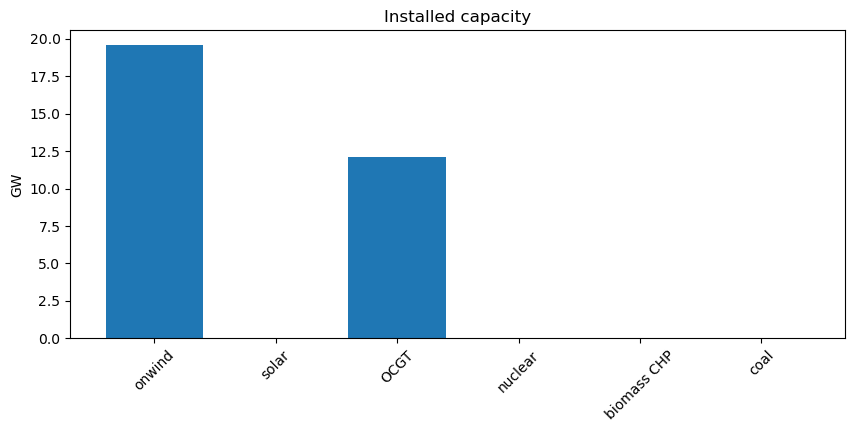

In [260]:
# Extract results
gen_cap = network.generators.p_nom_opt
gen_prod = network.generators_t.p

# Plotting the resulting capacity
fig, ax = plt.subplots(1, 1, figsize=(10,4), sharey=True)
ax.bar(gen_cap.index, gen_cap.values/1E3)
ax.set_xticks(ticks = gen_cap.index, labels = gen_cap.index.str.replace("FIN_", "").str.replace("_", " "), rotation=45)
ax.set_title("Installed capacity")
ax.set_ylabel("GW")
plt.show()

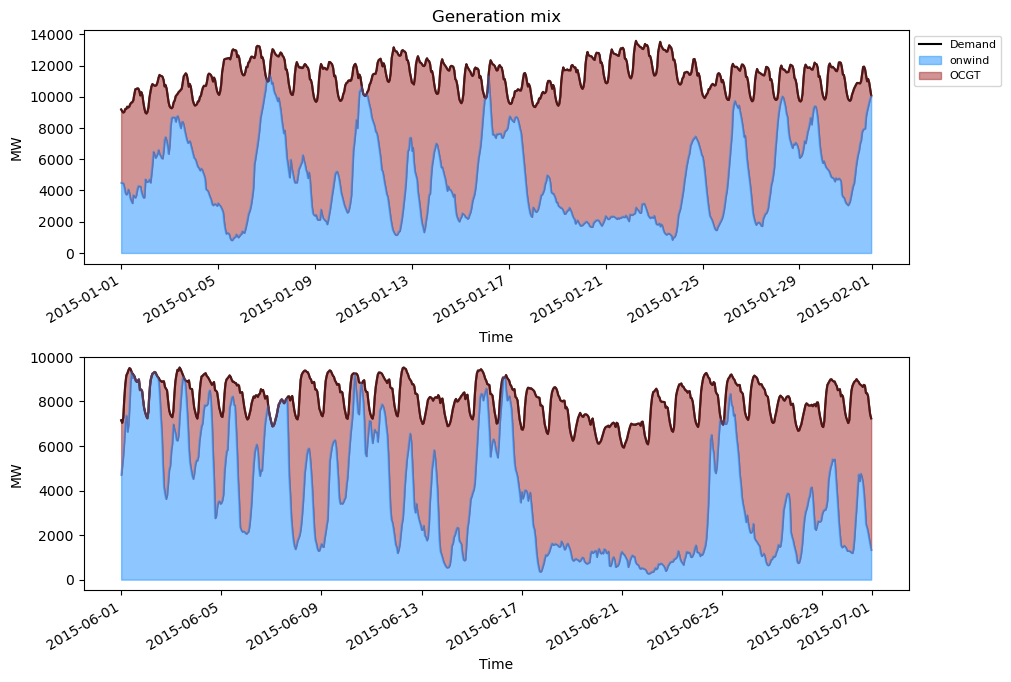

In [261]:
# Plot a week of generation
start_date_jan = "2015-01-01"
end_date_jan = "2015-01-31"
start_date_jun = "2015-06-01"
end_date_jun = "2015-06-30"

demand_jan = demand.loc[start_date_jan:end_date_jan]
generator_jan = gen_prod.loc[start_date_jan:end_date_jan,  (gen_prod != 0).any(axis=0)]

demand_jun = demand.loc[start_date_jun:end_date_jun, ]
generator_jun = gen_prod.loc[start_date_jun:end_date_jun, (gen_prod != 0).any(axis=0)]


fig, ax = plt.subplots(2, 1, figsize=(10,7))
ax[0].plot(demand_jan.index, demand_jan.values, label="Demand", color="black")
generator_jan.plot.area(ax=ax[0], alpha=0.5, stacked=True, color=generator_jan.columns.map(network.carriers.color), legend=True)
ax[0].set_title("Generation mix")
ax[0].set_ylabel("MW")
ax[0].set_xlabel("Time")
ax[0].legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)

ax[1].plot(demand_jun.index, demand_jun.values, label="Demand", color="black")
generator_jun.plot.area(ax=ax[1], alpha=0.5, stacked=True, color=generator_jan.columns.map(network.carriers.color), legend=False)
ax[1].set_ylabel("MW")
ax[1].set_xlabel("Time")

plt.subplots_adjust(hspace=0.4, bottom=0.1, right=0.95, top=0.9)
plt.show()

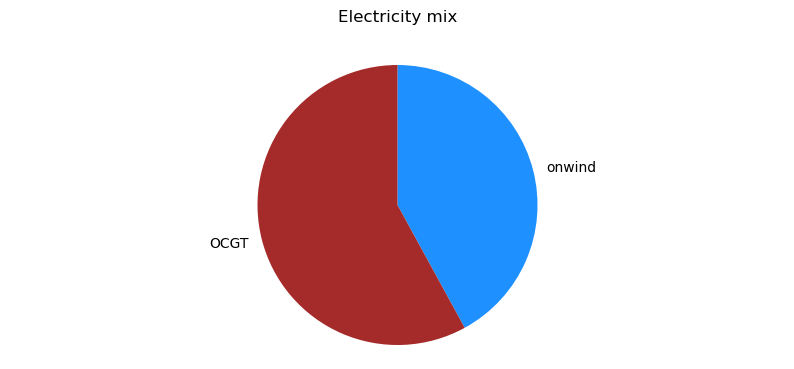

In [262]:
# Plot electricity mix
energy_production = network.generators_t.p
energy_sum = energy_production.sum(axis=0)
energy_sum = energy_sum[energy_sum != 0]

fig, ax = plt.subplots(1, 1, figsize=(10,4), sharey=True)
plt.pie(energy_sum.values, labels=energy_sum.index, colors=energy_sum.index.map(network.carriers.color), startangle=90, counterclock=False);
plt.axis('equal')
plt.title('Electricity mix', y=1.07)
plt.show()

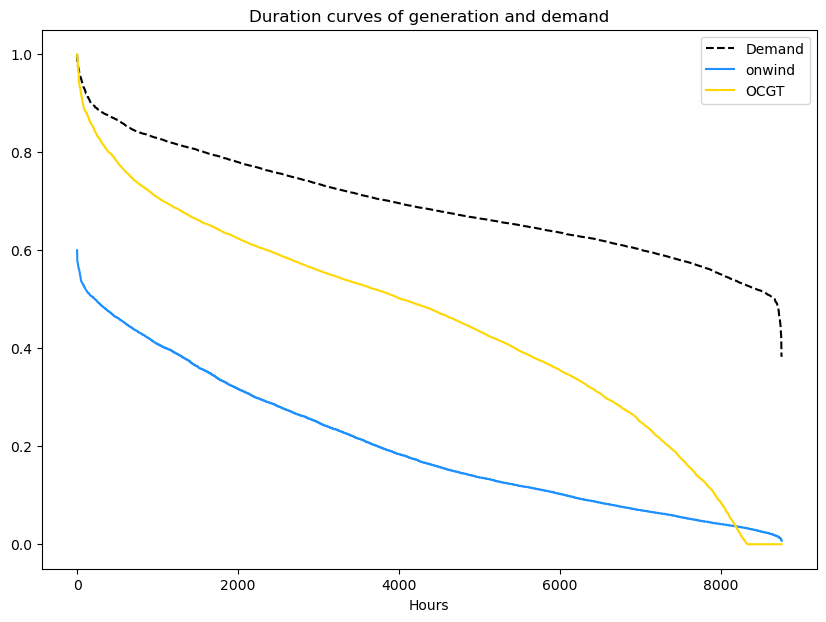

In [263]:
# Plot duration curves of generation and demand
fig, ax = plt.subplots(1, 1, figsize=(10,7))
ax.plot((demand/max(demand)).sort_values(ascending=False).reset_index(drop=True), label="Demand", color="black", linestyle="--")

for i, col in enumerate(energy_sum.index):
    ax.plot((energy_production[col]/gen_cap[col]).sort_values(ascending=False).reset_index(drop=True), label=col, color=colors[i])

plt.legend()
plt.title("Duration curves of generation and demand")
plt.xlabel("Hours")
plt.show()

## B: CO2 limits

In [264]:
# Add a CO2 limit constraint, for now a dummy value
network.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=119E5, #11.9MtCO2
    type="primary_energy",
)

In [277]:
# Prepare for sensitivity analysis
sensitivity_cost = {}
sensitivity_capacity = {}
sensitivity_production = {}
co2_price = {}

# Compute the total system cost (capital + operational) for the current network
def system_cost(n):
    tsc = n.statistics.capex() + n.statistics.opex()
    return tsc.droplevel(0).div(1e6)  # million €/a

# Define the CO2 limits for sensitivity analysis and run the optimization for each limit
co2Limits = [50, 25, 11.9, 6, 3, 0]
for co2 in co2Limits:
    network.global_constraints.loc["CO2Limit", "constant"] = co2 * 1e6
    
    with suppress_stdout(): # Reduce output
        network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})

    
    sensitivity_cost[co2] = system_cost(network)
    sensitivity_capacity[co2] = network.generators.p_nom_opt.copy()
    sensitivity_production[co2] = network.generators_t.p.sum(axis=0)
    co2_price[co2] = -network.global_constraints.mu['CO2Limit']

INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  9.59it/s]
INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-07q0vp5_.lp
INFO:gurobipy:Reading time = 0.42 seconds
INFO:gurobipy:obj: 113887 rows, 52566 columns, 232497 nonzeros
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 10.51it/s]
INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-a9w7dcxc.lp
INFO:gurobipy:Reading time = 0.45 seconds
INFO:gurobipy:obj: 113887 rows, 52566 columns, 232497 nonzeros
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 1

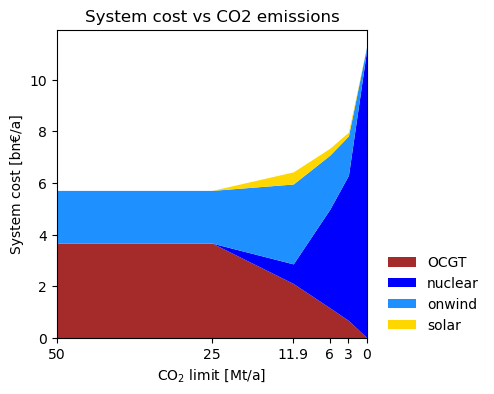

In [ ]:
sens_cost = pd.DataFrame(sensitivity_cost).T.div(1e3)  # billion Euro/a
sens_cap = pd.DataFrame(sensitivity_capacity).T
sens_prod = pd.DataFrame(sensitivity_production).T.div(1e3)  # GWh/a

# Include only technologies that are used in the network
sens_cost = sens_cost.loc[:, sens_cost.sum() != 0]


# Plot system cost vs CO2 emissions
sens_cost.plot.area(
    stacked=True, linewidth=0,
    color=sens_cost.columns.map(network.carriers.color),
    figsize=(4, 4), xlim=(min(co2Limits), max(co2Limits)),
    xlabel=r"CO$_2$ limit [Mt/a]",
    ylabel="System cost [bn€/a]",
)

plt.xticks(co2Limits, co2Limits)
plt.title("System cost vs CO2 emissions")
plt.legend(frameon=False, loc=(1.05, 0))
plt.gca().invert_xaxis()

## C: new weather

In [241]:
weather_years = [2001, 2010, 2015, 2017]

sensitivity_cost = {}
sensitivity_capacity = {}
sensitivity_production = {}

for year in weather_years:
    onshore = onshore_all[country].loc[onshore_all.index.year == year]
    solar = solar_all[country].loc[solar_all.index.year == year]

    # Update model
    network.generators_t["p_max_pu"] = network.generators_t["p_max_pu"].assign(
                                       onwind=onshore.values, solar=solar.values )

    with suppress_stdout(): # Reduce output
        network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})


    sensitivity_cost[year] = system_cost(network)
    sensitivity_capacity[year] = network.generators.p_nom_opt.copy()
    sensitivity_production[year] = network.generators_t.p.copy()

sens_cost = pd.DataFrame(sensitivity_cost).T.div(1e3)  # billion Euro/a
sens_cap = pd.DataFrame(sensitivity_capacity).T

INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  9.79it/s]
INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-bdhseen2.lp
INFO:gurobipy:Reading time = 0.41 seconds
INFO:gurobipy:obj: 113886 rows, 52566 columns, 206233 nonzeros
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 10.98it/s]
INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-y7jpb8o8.lp
INFO:gurobipy:Reading time = 0.37 seconds
INFO:gurobipy:obj: 113886 rows, 52566 columns, 206225 nonzeros
INFO:gurobipy:Set parameter Username
INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  

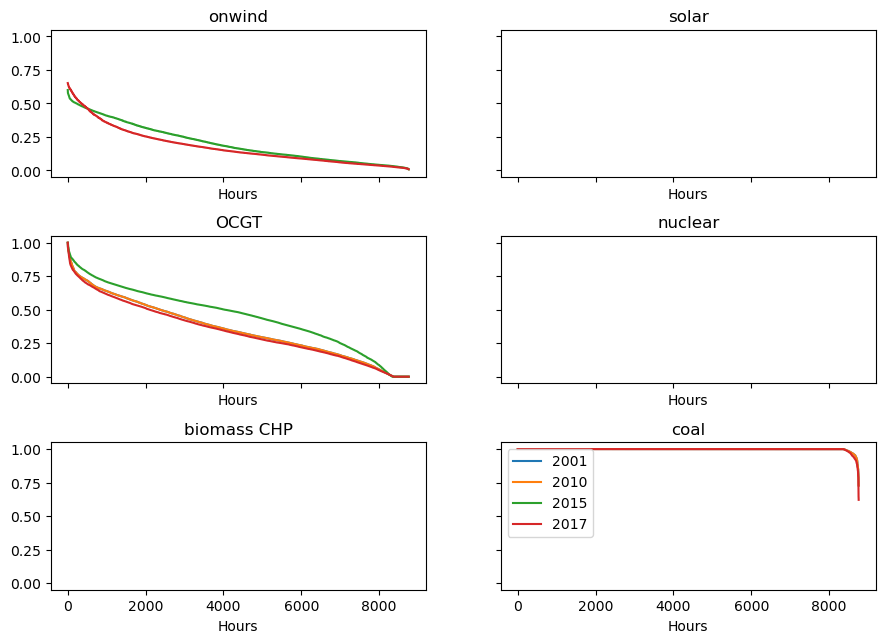

In [ ]:
# Plot duration curves for each technology and year
fig , ax = plt.subplots(3, 2, figsize=(10,7), sharex=True, sharey=True)

for i, tech in enumerate(sens_cap.columns):
    for year in weather_years:
        ax[i//2, i%2].plot((sensitivity_production[year][tech]/sens_cap.loc[year, tech]).sort_values(ascending=False).reset_index(drop=True), label=year)
        ax[i//2, i%2].set_title(tech)
        ax[i//2, i%2].set_xlabel("Hours")

plt.legend()
plt.subplots_adjust(hspace=0.4, bottom=0.1, right=0.95, top=0.9)
plt.show()